## 4 - Implementing the Q-Learning Algorithm

In this section, I produce the code in order to simulate reinforcement learning using a First Visit Monte Carlo Algorithm.

In [2]:
import sys
sys.path.append('../src')

from environment import BlackjackEnv
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

`Q_table` is a q table and `prob_table` is same size probability table with 1/3 for all probs

In [3]:
def run_episode(env, Q_table, prob_table):
    episode_states = []

    state, info = env.reset()

    while not env.done:
        if state[0] == 25:
            _, _, env.done, _, _ = env.step(0)
        else:
            Q_index = state[0] * env.observation_space[1].n + state[1]

            valid_indices = np.where(info["action_mask"] == 1)[0]

            action = np.argmax(Q_table[Q_index, valid_indices])

            action_prob = prob_table[Q_index][action]

            if np.random.rand() < action_prob:
                final_action = action
            else:
                final_action = np.random.choice(valid_indices[valid_indices != action])

            new_state, reward, _, _, info = env.step(final_action)

            episode_states.append((state, final_action, reward))

            state = new_state
        
    return episode_states

In [4]:
def update_Q_table(env, episode_states, Q_table, alpha, gamma):
    for round, (state, action, _) in enumerate(episode_states):
        total_reward = 0

        for gamma_exponent, (_, _, round_reward) in enumerate(episode_states[round:]):
            total_reward += (gamma ** gamma_exponent) * round_reward

        Q_index = state[0] * env.observation_space[1].n + state[1]
        
        Q_table[Q_index][action] += alpha * (total_reward - Q_table[Q_index][action])

def update_prob_table(env, episode_states, Q_table, prob_table, epsilon):
    for state, _, _ in episode_states:
        Q_index = state[0] * env.observation_space[1].n + state[1]

        action = np.argmax(Q_table[Q_index])

        initial_value = prob_table[Q_index][action]

        prob_table[Q_index][action] = min(1, prob_table[Q_index][action] + 1 - epsilon)

        other_prob_change = (prob_table[Q_index][action] - initial_value) / 2

        mask = np.arange(3)[np.arange(3) != action]

        prob_table[Q_index, mask] -= other_prob_change



In [5]:
def run_training(env, episodes):
    Q_table = np.zeros((env.observation_space[0].n * env.observation_space[1].n, env.action_space.n), dtype=np.float16)
    prob_table = np.full_like(Q_table, 1 / 3, dtype=np.float16)

    alpha = 0.001
    gamma = 0.7
    epsilon = 0.9999
    MIN_EPSILON = 0.5
    EPSILON_DECAY = 0.000001

    for _ in tqdm(range(episodes)):
        episode_states = run_episode(env, Q_table, prob_table)

        epsilon = max(epsilon - EPSILON_DECAY, MIN_EPSILON)

        update_Q_table(env, episode_states, Q_table, alpha, gamma)
        update_prob_table(env, episode_states, Q_table, prob_table, epsilon)

    return Q_table

In [7]:
env = BlackjackEnv()

Q_table = run_training(env, 10000000)

100%|██████████| 10000000/10000000 [03:20<00:00, 49847.74it/s]


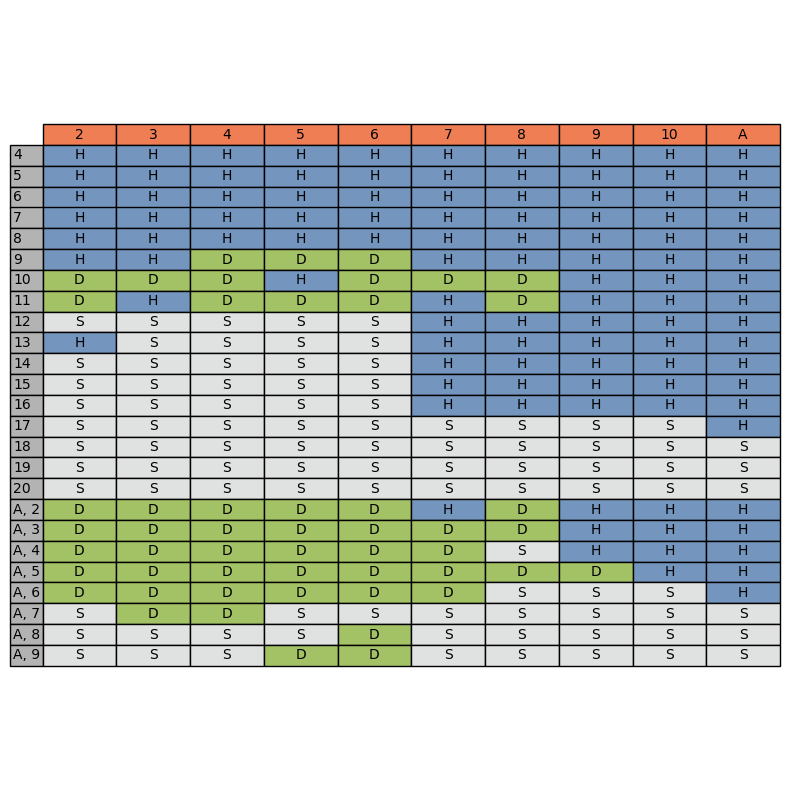

In [8]:
row_labels = list(range(4, 21)) + [f'A, {x}' for x in list(range(2, 10))]
col_labels = list(range(2, 11)) + ['A']

df = pd.DataFrame(index=row_labels, columns=col_labels)
colors = []

action_map = {0: 'H', 1: 'S', 2: 'D'}
color_map = {'H': '#7495BD', 'S': '#E0E1E1', 'D': '#A3C165'}

for i, hand in enumerate(row_labels):
    colors.append([])
    for j, up_card in enumerate(col_labels):
        action = action_map[np.argmax(Q_table[i * 10 + j])]
        df.loc[hand, up_card] = action
        colors[i].append(color_map[action])

fig, ax = plt.subplots(figsize=(8,8))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(
    cellText=df.values,
    cellColours=colors,
    cellLoc='center',
    colLabels=col_labels,
    colColours=['#EF7E54' for _ in range(len(col_labels))],
    rowLabels=row_labels,
    rowColours=['#B3B3B3' for _ in range(len(row_labels))],
    loc='center'
)

fig.tight_layout()

plt.show()

In [9]:
env = BlackjackEnv()

total_rewards = 0
episodes = 10000000

for _ in tqdm(range(episodes)):
    state, info = env.reset()

    while env.done == False:
        if state[0] == 25:
            _, reward, _, _, _ = env.step(1)
            total_rewards += reward
        else:
            Q_index = state[0] * env.observation_space[1].n + state[1]
            action = np.argmax(Q_table[Q_index, np.where(info["action_mask"] == 1)[0]])

            new_state, reward, _, _, info = env.step(action)
            state = new_state
            total_rewards += reward
        
avg_reward = total_rewards / episodes
print(f'{avg_reward * 100:.2f}')

100%|██████████| 10000000/10000000 [01:44<00:00, 95981.50it/s]

-5.56
